In [2]:
import pandas as pd

df1 = pd.read_stata('https://github.com/QuantEcon/QuantEcon.lectures.code/raw/master/ols/maketable1.dta')
df1.head()

,shortnam,euro1900,excolony,avexpr,logpgp95,cons1,cons90,democ00a,cons00a,extmort4,logem4,loghjypl,baseco
0,AFG,0.000000,1.0,NaN,NaN,1.0,2.0,1.0,1.0,93.699997,4.540098,NaN,NaN
1,AGO,8.000000,1.0,5.363636,7.770645,3.0,3.0,0.0,1.0,280.000000,5.634789,-3.411248,1.0
2,ARE,0.000000,1.0,7.181818,9.804219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ARG,60.000004,1.0,6.386364,9.133459,1.0,6.0,3.0,3.0,68.900002,4.232656,-0.872274,1.0
4,ARM,0.000000,0.0,NaN,7.682482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


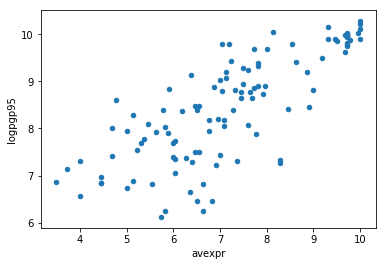

In [3]:
import matplotlib.pyplot as plt

df1.plot(x="avexpr", y='logpgp95', kind='scatter')
plt.show()

We use the following model:

$$logpgp95_i = \beta_0 + \beta_iavexpr_i + \epsilon_i$$

Note we add the constant term so that the OLS model will generate a $\beta_0$ term. Consider the matrix interpretation of the explanatory variables in which we define the $\bf{x}$ matrix as:

$$
{\bf{x}} = \begin{bmatrix}
    1 & x_{11}& \dots & x_{1m}\\
    1 & x_{12} & \dots & x_{2m}\\
    \vdots &\vdots & \ddots & \vdots \\ 
    1 & x_{1n} & \dots & x_{nm}\\
\end{bmatrix}
$$

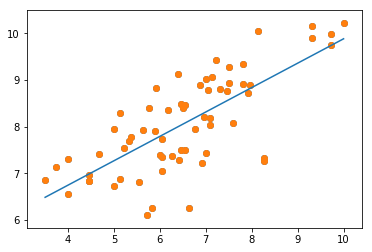

In [16]:
# First drop NA's -- required by numpy
import numpy as np

df1_sub = df1.dropna(subset=['logpgp95', 'avexpr'])
df1_sub = df1_sub[df1_sub['baseco'] == 1]

x = df1_sub['avexpr']
y = df1_sub['logpgp95']
labels = df1_sub['shortnam']

plt.scatter(x,y)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x,y,1))(np.unique(x)))
plt.show()

Now, we use an OLS model

$$\min_\hat{\beta} \sum^N_{i=1} \hat{\epsilon_i^2}$$

In [29]:
import statsmodels.api as sm
df1['const'] =1

In [30]:
reg1 = sm.OLS(endog=df1['logpgp95'], exog=df1[['const', 'avexpr']], missing = 'drop')

In [35]:
print(reg1.fit().summary())

                            OLS Regression Results                            
Dep. Variable:               logpgp95   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     171.4
Date:                Fri, 03 Nov 2017   Prob (F-statistic):           4.16e-24
Time:                        03:05:17   Log-Likelihood:                -119.71
No. Observations:                 111   AIC:                             243.4
Df Residuals:                     109   BIC:                             248.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6261      0.301     15.391      0.0

We can also do some prediction:

In [38]:
mean = np.mean(df1_sub['avexpr'])
mean

6.515625

In [40]:
reg1.fit().predict(exog=[1, mean])

array([ 8.09156367])

Cool!

In [46]:
df2 = pd.read_stata('https://github.com/QuantEcon/QuantEcon.lectures.code/raw/master/ols/maketable2.dta')
df2['const'] = 1

X2 = ['const', 'avexpr', 'lat_abst', 'asia', 'africa', 'other']
reg2 = sm.OLS(df2['logpgp95'], df2[X2], missing='drop')

In [52]:
from statsmodels.iolib.summary2 import summary_col

results_table = summary_col(results=[reg1.fit(), reg2.fit()], stars = True)

In [53]:
print(results_table)


         logpgp95 I logpgp95 II
-------------------------------
africa              -0.9164*** 
                    (0.1663)   
asia                -0.1531    
                    (0.1548)   
avexpr   0.5319***  0.3896***  
         (0.0406)   (0.0507)   
const    4.6261***  5.8511***  
         (0.3006)   (0.3396)   
lat_abst            0.3326     
                    (0.4455)   
other               0.3035     
                    (0.3748)   
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


### Endogeniety

We implement as 2SOLS based on Acemoglu et al. 2001

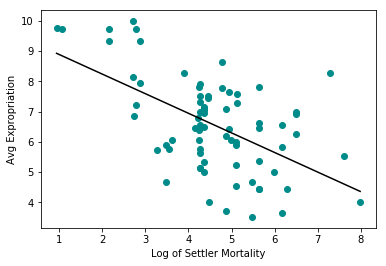

In [67]:
df1_sub2 = df1.dropna(subset=['logem4', 'avexpr'])

x = df1_sub2['logem4']
y = df1_sub2['avexpr']

plt.scatter(x,y, color = "darkcyan")
plt.xlabel("Log of Settler Mortality")
plt.ylabel("Avg Expropriation")
plt.plot(np.unique(x),
         np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),
         color='black')
plt.show()

#### First stage

The first step in 2SLS is to regress the endogenous variable on the instrument. The instrument is the set of all exogenous variables in the model. In this case this is just settler mortality rates *$logem4_i$* and a constant.

In [70]:
df4 = pd.read_stata('https://github.com/QuantEcon/QuantEcon.lectures.code/raw/master/ols/maketable4.dta')
df4 = df4[df4['baseco'] == 1]

df4['const'] = 1

fs_res = sm.OLS(df4['avexpr'], df4[['const', 'logem4']], missing = 'drop').fit()

print(fs_res.summary())

                            OLS Regression Results                            
Dep. Variable:                 avexpr   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     22.95
Date:                Fri, 03 Nov 2017   Prob (F-statistic):           1.08e-05
Time:                        04:11:04   Log-Likelihood:                -104.83
No. Observations:                  64   AIC:                             213.7
Df Residuals:                      62   BIC:                             218.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.3414      0.611     15.296      0.0

In [72]:
df4['predicted_avexpr'] = fs_res.predict()

ss_res = sm.OLS(df4['logpgp95'], df4[['const', 'predicted_avexpr']]).fit()

print(ss_res.summary())

                            OLS Regression Results                            
Dep. Variable:               logpgp95   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     56.60
Date:                Fri, 03 Nov 2017   Prob (F-statistic):           2.66e-10
Time:                        04:13:03   Log-Likelihood:                -72.268
No. Observations:                  64   AIC:                             148.5
Df Residuals:                      62   BIC:                             152.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.9097      0.823  

I wil add some res analysis of the first stage here for fun:

In [76]:
pred = fs_res.predict()

In [78]:
residuals = df4['avexpr'] - pred

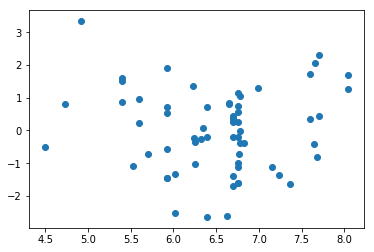

In [80]:
plt.scatter(pred, residuals)
plt.show()

Since manual 2SLS will mistake the standard errors we now do this automatically using the linearmodels IV model.

In [87]:
from linearmodels.iv import IV2SLS

iv = IV2SLS(dependent=df4['logpgp95'],
            exog = df4['const'], endog = df4['avexpr'],
           instruments = df4['logem4']).fit(cov_type='unadjusted')

print(iv.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:               logpgp95   R-squared:                      0.1870
Estimator:                    IV-2SLS   Adj. R-squared:                 0.1739
No. Observations:                  64   F-statistic:                    37.568
Date:                Fri, Nov 03 2017   P-value (F-stat)                0.0000
Time:                        04:24:32   Distribution:                  chi2(1)
Cov. Estimator:            unadjusted                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          1.9097     1.0106     1.8897     0.0588     -0.0710      3.8903
avexpr         0.9443     0.1541     6.1293     0.00